In [60]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [3]:
courses = pd.read_csv('OneDrive/Área de Trabalho/mac434/anonimized_courses.csv')
logs = pd.read_csv('OneDrive/Área de Trabalho/mac434/anonimized_logs.csv')
regs = pd.read_csv('OneDrive/Área de Trabalho/mac434/anonimized_registrations.csv')
sections = pd.read_csv('OneDrive/Área de Trabalho/mac434/anonimized_sections.csv')
tasks = pd.read_csv('OneDrive/Área de Trabalho/mac434/anonimized_tasks.csv')
users = pd.read_csv('OneDrive/Área de Trabalho/mac434/anonimized_users.csv')

Iniciar aqui a seleção dos 25 mais ativos, utilizando o critério de mais tempo assistindo vídeos na plataforma:

In [3]:
users.head()

,createdAt,special_flagged,uuid
0,2011-08-03,0,97665
1,2011-08-11,0,68492
2,2011-08-03,0,52463
3,2011-08-19,0,129570
4,2011-08-04,0,45524


In [4]:
courses.head()

,createdAt,level,publicatedAt,totalVideoTime,subCategory_id,situation,isProject,removedAt,uuid,substitute_uuid
0,2011-09-22,1,2011-09-22,51,30,PUBLISHED,0,NaN,588,NaN
1,2011-10-27,5,2011-10-27,72,21,PUBLISHED,0,NaN,840,NaN
2,2012-02-15,1,2012-02-15,112,1,PUBLISHED,0,NaN,764,NaN
3,2012-03-07,5,2012-03-07,83,21,PUBLISHED,0,NaN,720,NaN
4,2012-05-29,1,2012-05-29,70,48,PUBLISHED,0,NaN,937,NaN


In [47]:
logs.head()

,user_uuid,moment,kind,iterable_uuid
0,57928,2016-09-12,EXERCISE_ANSWERED,2918d775-73e8-4c33-a3b7-5f0726bbe3ca
1,73719,2016-09-12,EXERCISE_ANSWERED,1315cdde-14e1-412d-bc3b-5da04b7aa44a
2,38957,2016-09-12,EXERCISE_ANSWERED,2ec53649-0eae-4114-b21f-ad72d448180b
3,59788,2016-09-12,EXERCISE_ANSWERED,ad5ae7b6-918f-4dfe-8680-db2928fe732c
4,73719,2016-09-12,EXERCISE_ANSWERED,7e08ee37-3eb6-4412-a6dd-d01f5619d2a2


In [12]:
sections.head()

,number,active,uuid,course_uuid
0,1,1,3988,588
1,2,1,6725,588
2,3,1,3716,588
3,4,1,4125,588
4,5,1,5354,588


In [45]:
regs.head()

,user_uuid,course_uuid,createdAt,finishedAt,lastAccessDate,currentState
0,36802,113,2015-09-15 06:33:25,2015-09-28 21:54:56,2017-11-28 16:22:04,IN_PROGRESS
1,34892,764,2015-09-15 00:00:21,2016-03-01 14:11:05,2016-10-18 13:15:22,IN_PROGRESS
2,37440,764,2015-09-15 00:00:21,NaN,2015-09-15 00:00:21,IN_PROGRESS
3,58529,76,2015-09-15 00:00:20,NaN,2018-03-14 20:27:27,NOT_VISIBLE
4,48059,76,2015-09-15 00:00:20,NaN,2015-09-15 00:00:20,IN_PROGRESS


In [43]:
tasks.head()

,kind,duration,status,createdAt,uuid,course_uuid
0,VIDEO,31,ACTIVE,2015-10-21,21316,588
1,VIDEO,188,ACTIVE,2015-10-21,13646,588
2,HQ_EXPLANATION,0,ACTIVE,2015-10-21,45401,588
3,OPEN_QUESTION,0,ACTIVE,2015-10-21,37691,588
4,OPEN_QUESTION,0,ACTIVE,2015-10-21,9310,588


In [ ]:
tasks['kind'].value_counts()

In [23]:
logs['kind'].value_counts()

EXERCISE_ANSWERED      18000612
COURSE_FINISHED          426290
FORUM_POSTED              67213
FORUM_SOLVED              13963
CAREER_FINISHED           12514
DEGREE_FINISHED            9247
SUGGESTION_APPROVED        3558
PROJECT_APPROVED             74
Name: kind, dtype: int64

Análise dos alunos que interagem com a plataforma (através dos foruns):

In [98]:
logsForum = logs.copy()
logsForum.drop(['iterable_uuid'],axis=1,inplace=True)

logsForum = logsForum[logsForum.kind!='COURSE_FINISHED']
logsForum = logsForum[logsForum.kind!='CAREER_FINISHED']
logsForum = logsForum[logsForum.kind!='DEGREE_FINISHED']
logsForum = logsForum[logsForum.kind!='PROJECT_APPROVED']
logsForum = logsForum[logsForum.kind!='EXERCISE_ANSWERED']

logsForum['somaForum'] = logsForum.groupby(['user_uuid','moment'])['kind'].transform('count')
logsForum.drop_duplicates(subset=['user_uuid','moment'],inplace=True)
logsForum.drop(['kind'],axis=1,inplace=True)

logsForum.head()

,user_uuid,moment,somaForum
526,13258,2016-09-12,4
1010,119614,2016-09-12,2
1029,86326,2016-09-12,2
1755,85621,2016-09-12,1
1873,82046,2016-09-12,1


In [97]:
logsEx = logs[logs['user_uuid'].isin(logsForum['user_uuid'])]
logsEx.drop(['iterable_uuid'],axis=1,inplace=True)
logsEx['somaEx'] = logsEx.groupby(['user_uuid','moment'])['kind'].transform('count')
logsEx.drop_duplicates(subset=['user_uuid','moment'],inplace=True)
logsEx.drop(['kind'],axis=1,inplace=True)
logsEx.head()

C:\Users\gabri.DESKTOP-N0L5IAS\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\gabri.DESKTOP-N0L5IAS\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,user_uuid,moment,somaEx
0,57928,2016-09-12,47
2,38957,2016-09-12,2
16,117109,2016-09-12,3
20,88787,2016-09-12,3
21,16502,2016-09-12,11


In [96]:
teste = logsForum.merge(logsEx, left_on=['user_uuid','moment'], right_on=['user_uuid','moment'])
teste = teste[teste['somaForum'] >= 15]
teste.head()

,user_uuid,moment,somaForum,somaEx
311,5887,2016-09-23,21,25
497,121536,2016-09-30,20,27
834,121536,2016-10-13,17,73
1005,82046,2016-10-19,20,33
1366,5343,2016-10-31,17,33


In [95]:
activeYears = users[users['uuid'].isin(teste['user_uuid'])]
createdDates= [pd.to_datetime(d) for d in activeYears['createdAt']]
activeYears['yearsActive'] = [relativedelta(datetime.now(), d).years for d in createdDates]
activeYears.drop(['createdAt','special_flagged'],axis=1,inplace=True)
activeYears.head()

C:\Users\gabri.DESKTOP-N0L5IAS\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,uuid,yearsActive
2794,121536,8
3395,56236,8
10333,82624,6
18429,114664,5
19121,48055,5


In [94]:
avgPosts = teste.merge(activeYears,left_on='user_uuid',right_on='uuid')
avgPosts.drop(['uuid'],axis=1,inplace=True)
avgPosts['avg'] = avgPosts['somaForum']/avgPosts['yearsActive']
avgPosts.head()

,user_uuid,moment,somaForum,somaEx,yearsActive,avg
0,5887,2016-09-23,21,25,4,5.250
1,121536,2016-09-30,20,27,8,2.500
2,121536,2016-10-13,17,73,8,2.125
3,121536,2017-03-28,18,29,8,2.250
4,82046,2016-10-19,20,33,4,5.000


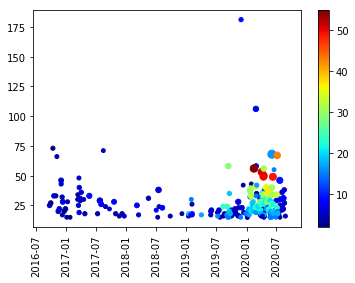

In [93]:
dates= [pd.to_datetime(d) for d in avgPosts['moment']]
plt.scatter(x=dates,y=avgPosts['somaEx'],c=avgPosts['avg'],s=avgPosts['somaForum'],cmap='jet')
plt.xticks(rotation='vertical')
plt.colorbar()
plt.show()

In [3]:
timeWatched = tasks[['duration','uuid']]
#remover 0 minutos (ruido)
timeWatched = timeWatched[timeWatched['duration'] > 0]
timeWatched.sort_values(by='duration', ascending=False).head()

,duration,uuid
3624,2649,26524
9876,2379,29717
3230,2372,62809
6676,2209,13311
2958,2094,15093


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001460BBD3080>]],
      dtype=object)

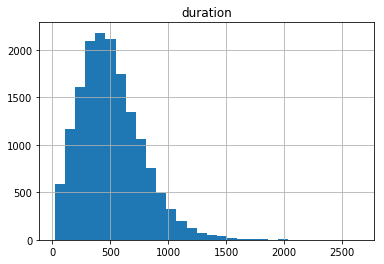

In [4]:
timeWatched.hist(column='duration',bins=30)

In [5]:
#pegar os top 25% com mais tempo assistido
top25 = timeWatched.sort_values(by='duration', ascending=False).head(int(len(timeWatched)*0.25))
top25.head()

,duration,uuid
3624,2649,26524
9876,2379,29717
3230,2372,62809
6676,2209,13311
2958,2094,15093


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001460BEB0A58>]],
      dtype=object)

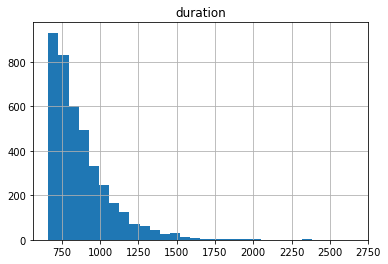

In [6]:
top25.hist(column='duration', bins=30)

Acima, temos a distribuição do tempo em que os alunos do quartil superior gastam na plataforma (Tempo em minutos X quantidade de alunos)

In [7]:
statuses = top25.merge(regs, left_on='uuid',right_on='user_uuid')
statuses.head()

,duration,uuid,user_uuid,course_uuid,createdAt,finishedAt,lastAccessDate,currentState
0,2649,26524,26524,928,2017-08-05 14:18:18,NaN,2019-06-07 15:31:44,IN_PROGRESS
1,2649,26524,26524,543,2017-08-08 07:29:22,NaN,2017-08-08 10:37:59,IN_PROGRESS
2,2649,26524,26524,49,2017-08-16 13:09:18,NaN,2017-08-19 18:10:32,IN_PROGRESS
3,2649,26524,26524,117,2017-08-16 13:45:16,NaN,2017-08-23 20:40:32,IN_PROGRESS
4,2649,26524,26524,1028,2017-10-05 15:51:58,NaN,2017-10-05 15:53:22,IN_PROGRESS


In [8]:
statuses = statuses[statuses.currentState!='NOT_VISIBLE']
statuses = statuses[statuses.currentState!='BOOKMARKED']

Aqui, fazemos a remoção de estados de curso irrelevantes para nossa análise, deixando apenas IN_PROGRESS e PAUSED a serem analisados

In [9]:
#curso completado -> com data e in_progress // curso pausado -> resto
statuses['completion'] = np.where((statuses['currentState']=='IN_PROGRESS') & (statuses['finishedAt'].notna()), 'completed', 'paused')

In [10]:
statuses.drop(['duration'],axis=1,inplace=True)
statuses.head()

,uuid,user_uuid,course_uuid,createdAt,finishedAt,lastAccessDate,currentState,completion
0,26524,26524,928,2017-08-05 14:18:18,NaN,2019-06-07 15:31:44,IN_PROGRESS,paused
1,26524,26524,543,2017-08-08 07:29:22,NaN,2017-08-08 10:37:59,IN_PROGRESS,paused
2,26524,26524,49,2017-08-16 13:09:18,NaN,2017-08-19 18:10:32,IN_PROGRESS,paused
3,26524,26524,117,2017-08-16 13:45:16,NaN,2017-08-23 20:40:32,IN_PROGRESS,paused
4,26524,26524,1028,2017-10-05 15:51:58,NaN,2017-10-05 15:53:22,IN_PROGRESS,paused


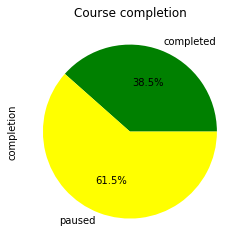

In [15]:
statuses.groupby('completion')['completion'].count().plot.pie(colors = ['green','yellow'], autopct='%1.1f%%',title='Course completion',)

In [17]:
statuses.groupby('completion')['completion'].count()

completion
completed     8475
paused       13562
Name: completion, dtype: int64

Pelo gráfico, percebe-se que a maioria dos alunos os quais consideramos "os mais estudiosos" não completam seus cursos, mas sim os pausam em pontos arbitrários, sem necessáriamente haver um critério

In [18]:
courses.head()

,createdAt,level,publicatedAt,totalVideoTime,subCategory_id,situation,isProject,removedAt,uuid,substitute_uuid
0,2011-09-22,1,2011-09-22,51,30,PUBLISHED,0,NaN,588,NaN
1,2011-10-27,5,2011-10-27,72,21,PUBLISHED,0,NaN,840,NaN
2,2012-02-15,1,2012-02-15,112,1,PUBLISHED,0,NaN,764,NaN
3,2012-03-07,5,2012-03-07,83,21,PUBLISHED,0,NaN,720,NaN
4,2012-05-29,1,2012-05-29,70,48,PUBLISHED,0,NaN,937,NaN


In [19]:
courses.groupby('level')['level'].count()

level
1     664
5     375
10     50
Name: level, dtype: int64

In [20]:
top25_courses = top25.merge(tasks, left_on='uuid',right_on='uuid')
top25_courses = top25_courses.merge(courses, left_on='course_uuid',right_on='uuid')
top25_courses.drop(['duration_x','duration_y','createdAt_x','createdAt_y','uuid_y'],axis=1,inplace=True)
top25_courses.head()

,uuid_x,kind,status,course_uuid,level,publicatedAt,totalVideoTime,subCategory_id,situation,isProject,removedAt,substitute_uuid
0,26524,VIDEO,ACTIVE,969,5,2014-11-17,152,30,PUBLISHED,0,NaN,NaN
1,49929,VIDEO,ACTIVE,969,5,2014-11-17,152,30,PUBLISHED,0,NaN,NaN
2,38117,VIDEO,ACTIVE,969,5,2014-11-17,152,30,PUBLISHED,0,NaN,NaN
3,32023,VIDEO,ACTIVE,969,5,2014-11-17,152,30,PUBLISHED,0,NaN,NaN
4,29717,VIDEO,ACTIVE,818,5,2016-04-12,176,63,DISABLED,0,2020-07-17,649.0


In [21]:
top25_courses.groupby('level')['level'].count()

level
1     2357
5     1469
10     177
Name: level, dtype: int64

Temos abaixo o gráfico que ilustra uma predominância de cursos considerados "mais fáceis" dentre esse público.

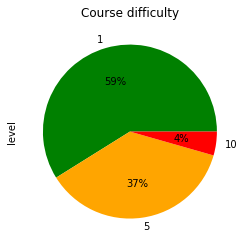

In [23]:
top25_courses.groupby('level')['level'].count().plot.pie(colors = ['green','orange','red'], autopct='%1.0f%%',title='Course difficulty')

In [18]:
teste = statuses.merge(top25_courses, left_on='uuid',right_on='uuid_x')
teste.drop(['uuid_x', 'course_uuid_y'],axis=1,inplace=True)
teste['completion'] = teste['completion'].replace('completed', 1)
teste['completion'] = teste['completion'].replace('paused', 0)
teste['courseCount'] = teste.groupby('uuid')['course_uuid_x'].transform('count')
teste['completionRate'] = 100*teste.groupby(by=['uuid'])['completion'].transform('sum')/teste['courseCount']
teste = teste[['uuid','completionRate','courseCount']]
teste.drop_duplicates(subset=['uuid'],keep='first',inplace=True)
teste.head()

,uuid,completionRate,courseCount
0,26524,24.000000,25
25,15093,100.000000,3
28,47481,33.333333,15
43,11347,33.333333,3
46,26188,60.000000,5


Finalmente, temos abaixo uma distribuição ta taxa de conclusão dos cursos entre os 25% mais ativos na plataforma.

Text(0.5, 1.0, 'Taxa de completude dos cursos')

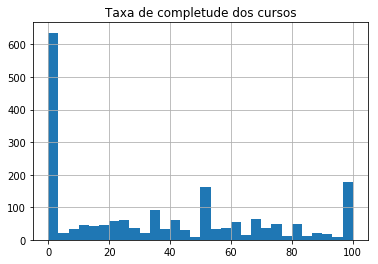

In [23]:
teste.hist(column='completionRate',bins=30)
plt.title('Taxa de completude dos cursos')